In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from datasets import Dataset

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load Dataset

In [3]:
data = pd.read_csv("/content/Combined Data.csv")

In [ ]:
data.dropna(inplace = True)
data

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data = data.sample(n = 6000, random_state = 42).reset_index(drop = True)

In [ ]:
data

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
...,...,...
5995,What is around you right now? A photo? A comfo...,Depression
5996,I am tired. I am ready for everything to be ov...,Suicidal
5997,? What if I am at a friends party and a man wh...,Stress
5998,if it add any kind of info m almost the thing ...,Depression


# Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_statement(text):
  #lower casing
  text = text.lower()

  #remove everything except letter and spaces
  text = re.sub(r"[^a-zA-Z\s]", "", text)

  #remove stopwords
  text = ' '.join([word for word in text.split() if word not in stop_words])

  #remove extra spaces
  text = re.sub(r"\s+", " ", text).strip()

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
clean_statement("O ererp o i love to east Banna")

'ererp love east banna'

In [ ]:
data['statement'] = data['statement'].apply(clean_statement)

In [ ]:
data

,statement,status
0,im lazy complain ba ihh,Normal
1,think wifi iphone broken quot connect quot act...,Normal
2,good tracking apps ive trying find apps track ...,Bipolar
3,recently looked reddit found place actually qu...,Depression
4,thats favorite thing,Normal
...,...,...
5995,around right photo comfortable place sit beaut...,Depression
5996,tired ready everything life pointless painful ...,Suicidal
5997,friends party man whispers ear likes stare tou...,Stress
5998,add kind info almost thing ive always felt kin...,Depression


In [ ]:
data['status'].value_counts()

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

X = data.drop('status', axis=1)
y = data['status']

X_resampled, y_resampled = ros.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
print(data['status'].value_counts())

status
Normal                  1894
Bipolar                 1894
Depression              1894
Suicidal                1894
Stress                  1894
Personality disorder    1894
Anxiety                 1894
Name: count, dtype: int64


In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])
data

,statement,status,label
0,im lazy complain ba ihh,Normal,3
1,think wifi iphone broken quot connect quot act...,Normal,3
2,good tracking apps ive trying find apps track ...,Bipolar,1
3,recently looked reddit found place actually qu...,Depression,2
4,thats favorite thing,Normal,3
...,...,...,...
13253,cannot afford therapist social anxiety depress...,Suicidal,6
13254,would like die simplei would really like suffe...,Suicidal,6
13255,death day time set affairs might even get bedr...,Suicidal,6
13256,hard seeing others live life would kill know w...,Suicidal,6


In [ ]:
#train test split
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size= 0.2)

In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encoding = tokenizer(list(train_texts), padding = True, truncation = True, max_length = 200)
test_encoding = tokenizer(list(test_texts), padding = True, truncation = True, max_length = 200)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Convert to dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encoding['input_ids'], 'attention_mask': train_encoding['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encoding['input_ids'], 'attention_mask': test_encoding['attention_mask'], 'labels': test_labels.tolist()})


# Model Finetuning

In [ ]:
print("Loading DistilBERT model...")
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

Loading DistilBERT model...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Evaluate after each epoch
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True, # Load the best model at the end
    metric_for_best_model="accuracy",
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aungthuphyo13072021 (aungthuphyo13072021-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.538800,0.414350,0.850679,0.842391,0.857022,0.850679
2,0.190200,0.244751,0.911765,0.910946,0.911517,0.911765


TrainOutput(global_step=1326, training_loss=0.6588478066802564, metrics={'train_runtime': 475.6281, 'train_samples_per_second': 44.598, 'train_steps_per_second': 2.788, 'total_flos': 1097714458219200.0, 'train_loss': 0.6588478066802564, 'epoch': 2.0})

# Model Evaluation

In [ ]:
print("\nEvaluating on the test set...")
test_results = trainer.evaluate(test_dataset)

print("\nTest Set Results:")
print(test_results)


Evaluating on the test set...



Test Set Results:
{'eval_loss': 0.24475131928920746, 'eval_accuracy': 0.9117647058823529, 'eval_f1': 0.9109463870264091, 'eval_precision': 0.9115170148014762, 'eval_recall': 0.9117647058823529, 'eval_runtime': 15.544, 'eval_samples_per_second': 170.613, 'eval_steps_per_second': 10.679, 'epoch': 2.0}


In [ ]:
print("\nTest Classification Report:")
test_preds = trainer.predict(test_dataset)
preds_flat = np.argmax(test_preds.predictions, axis=-1)
labels_flat = test_preds.label_ids
print(classification_report(labels_flat, preds_flat, target_names=label_encoder.classes_))


Test Classification Report:


                      precision    recall  f1-score   support

             Anxiety       0.97      0.98      0.97       370
             Bipolar       0.99      0.99      0.99       402
          Depression       0.81      0.71      0.75       381
              Normal       0.90      0.91      0.91       353
Personality disorder       0.99      1.00      1.00       383
              Stress       0.96      0.98      0.97       398
            Suicidal       0.75      0.81      0.78       365

            accuracy                           0.91      2652
           macro avg       0.91      0.91      0.91      2652
        weighted avg       0.91      0.91      0.91      2652



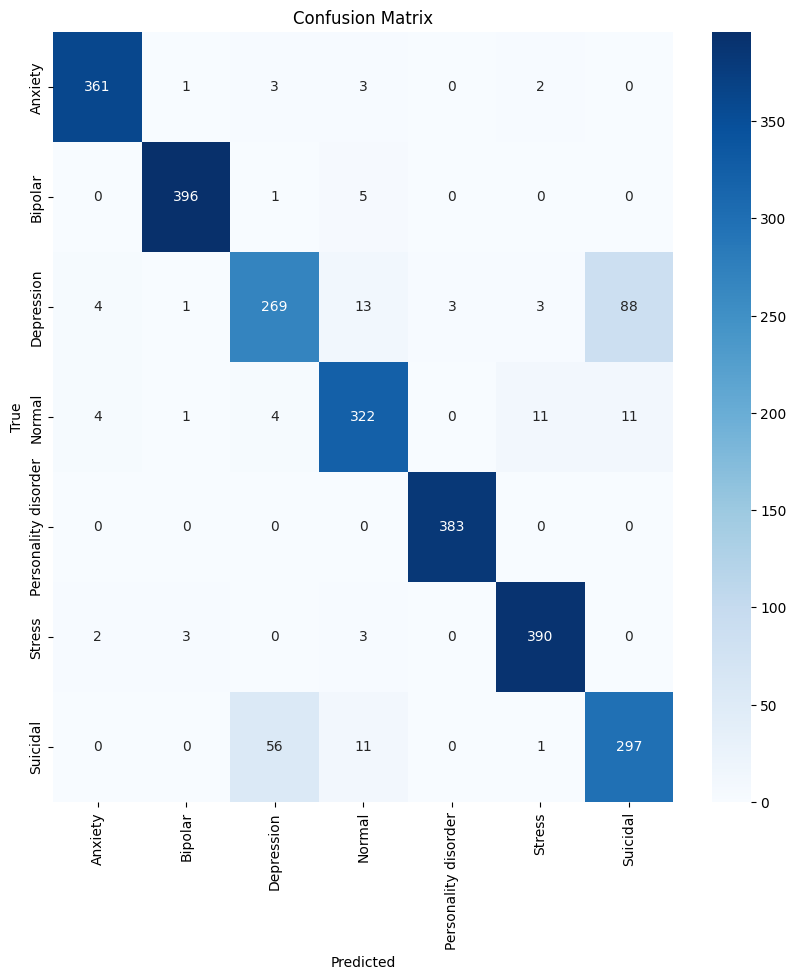

In [ ]:
from sklearn.metrics import confusion_matrix

prediction_output = trainer.predict(test_dataset)
predictions_logits = prediction_output.predictions
true_labels = prediction_output.label_ids

predicted_labels = np.argmax(predictions_logits, axis = 1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save and Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.save_model('/content/drive/MyDrive/saved_mental_status_bert')
tokenizer.save_pretrained('/content/drive/MyDrive/saved_mental_status_bert')

('/content/drive/MyDrive/saved_mental_status_bert/tokenizer_config.json',
 '/content/drive/MyDrive/saved_mental_status_bert/special_tokens_map.json',
 '/content/drive/MyDrive/saved_mental_status_bert/vocab.txt',
 '/content/drive/MyDrive/saved_mental_status_bert/added_tokens.json')

In [ ]:
import pickle

pickle.dump(label_encoder, open('/content/drive/MyDrive/label_encoder.pkl', 'wb'))

from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

model  = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/saved_mental_status_bert')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/saved_mental_status_bert')

label_encoder = pickle.load(open('/content/drive/MyDrive/label_encoder.pkl', 'rb'))

# Detection System

In [ ]:
import torch

def detection(text):
  text = clean_statement(text)
  inputs = tokenizer(text, return_tensors = 'pt', padding = True, truncation = True, max_length = 200)
  # Remove token_type_ids if present, as DistilBERT models do not use them
  if 'token_type_ids' in inputs:
      del inputs['token_type_ids']
  outputs = model(**inputs)
  logits = outputs.logits
  prediction_label = torch.argmax(logits, dim = 1).item()
  predicted_label = label_encoder.inverse_transform([prediction_label])

  return predicted_label

In [ ]:
text = "I feel so lonely"
detection(text)

array(['Depression'], dtype=object)

In [ ]:
text = "I am happy that i have many friends"
detection(text)

array(['Normal'], dtype=object)

In [ ]:
text = "I don't want to live anymore because every hates me"
detection(text)

array(['Suicidal'], dtype=object)

In [ ]:
text = "ကျွန်တော် တစ်ယောက်တည်းလို့ ခံစားနေတယ်။"
detection(text)

array(['Normal'], dtype=object)

In [ ]:
text = "ကျွန်တော် သူငယ်ချင်းအများကြီးရှိလို့ ဝမ်းသာနေတယ်။"
detection(text)

array(['Normal'], dtype=object)

In [ ]:
text = "လူတိုင်းက ကျွန်တော်ကို မုန်းကြလို့ နောင်တလျှင် မနေချင်တော့ဘူး။"
detection(text)

array(['Normal'], dtype=object)

# Test - 2

In [ ]:
import pandas as pd
import asyncio
# Import the Translator
!pip install googletrans
# Install and apply nest_asyncio to allow nested event loops in Colab
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

from googletrans import Translator

# Initialize the translator globally
try:
    translator = Translator()
except Exception as e:
    print(f"Translator initialization failed: {e}. Ensure you have an internet connection.")
    translator = None

async def translate_my_to_en(text):
    """
    Translates Burmese text (my) to English (en).
    """
    if pd.isna(text) or text.strip() == "":
        return ""

    # Use the translator if initialized
    if translator:
        try:
            # Source language is Burmese ('my'), Destination is English ('en')
            translated_text = await translator.translate(text, src='my', dest='en')
            return translated_text.text

        except Exception as e:
            print(f"Translation error for text '{text}': {e}")
            return text # Return original text on failure
    else:
        # Fallback if translator is not available
        return f"[Translation Failed] Placeholder for: {text}"


burmese_text = "လူတိုင်းက ကျွန်တော်ကို မုန်းကြလို့ နောင်တလျှင် မနေချင်တော့ဘူး"
print(f"Original Burmese Text: {burmese_text}")

# Run the async function
english_translation = asyncio.run(translate_my_to_en(burmese_text))
print(f"English Translation: {english_translation}")

/usr/lib/python3.12/pathlib.py:404: RuntimeWarning: coroutine 'translate_my_to_en' was never awaited
  parsed = [sys.intern(str(x)) for x in rel.split(sep) if x and x != '.']


Original Burmese Text: လူတိုင်းက ကျွန်တော်ကို မုန်းကြလို့ နောင်တလျှင် မနေချင်တော့ဘူး
English Translation: I don't want to regret it because everyone hates me


In [ ]:
async def translate_en_to_my(text):
    """
    Translates English text (en) to Burmese (my).
    """
    if pd.isna(text) or text.strip() == "":
        return ""

    # Use the translator if initialized
    if translator:
        try:
            # Source language is English ('en'), Destination is Burmese ('my')
            translated_text = await translator.translate(text, src='en', dest='my')
            return translated_text.text

        except Exception as e:
            # Note: Sometimes long/complex text can cause errors.
            print(f"Translation error for text '{text}': {e}")
            return text # Return original text on failure
    else:
        # Fallback if translator is not available
        return f"[Translation Failed] Placeholder for: {text}"


english_text = "I feel so lonely and sad all the time."
print(f"Original English Text: {english_text}")

burmese_translation = asyncio.run(translate_en_to_my(english_text))
print(f"Burmese Translation: {burmese_translation}")

Original English Text: I feel so lonely and sad all the time.
Burmese Translation: ငါအရမ်းအထီးကျန်နှင့်ဝမ်းနည်းဖွယ်ခံစားရတယ်။


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import asyncio
import nest_asyncio
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from datasets import Dataset
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from googletrans import Translator
!pip install langdetect
from langdetect import detect # For inference language detection

In [ ]:
#SETUP AND INITIALIZATION
nest_asyncio.apply()
nltk.download('stopwords', quiet=True)
stop_words = set(nltk.corpus.stopwords.words('english'))

In [ ]:
# Initialize Translator
try:
    translator = Translator()
except Exception as e:
    print(f"Translator initialization failed: {e}")
    translator = None

In [ ]:
MULTILINGUAL_MODEL_NAME = 'bert-base-multilingual-cased'

In [ ]:
data.dropna(inplace = True)
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
data = data.sample(n=6000, random_state=42).reset_index(drop=True)

In [ ]:
def clean_statement(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text) # Remove everything except letters and spaces (optimized for EN)

    # Only remove English stopwords if the text is English-like.
    # We keep the stopword removal for the EN statements
    text = ' '.join([word for word in text.split() if word not in stop_words])

    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
data['statement'] = data['statement'].apply(clean_statement)

In [ ]:
async def translate_en_to_my_async(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    if translator:
        try:
            # translator.translate is async → just await it
            result = await translator.translate(text, src='en', dest='my')
            # If result is an object with .text:
            return getattr(result, "text", result)
        except Exception as e:
            print("Translation error:", e, repr(text))
            return text
    return text


In [ ]:
translate_en_to_my("Hello, how are you?")


'ဟယ်လိုနေကောင်းလား?'

In [ ]:
data['lang'] = 'en'
en_df = data[data['lang'] == 'en'].copy()
en_df['statement'] = en_df['statement'].apply(translate_en_to_my)
en_df['lang'] = 'my'
data_aug = pd.concat([data, en_df], ignore_index=True)

data = data_aug
print(f"Data Augmented. New total samples: {len(data)}")

Translation error: Invalid input ConnectionInputs.RECV_PING in state ConnectionState.CLOSED 'wish socially acceptable ask important know question sounds resentful judgmental sounds like accusation almost im tired getting hurt overestimate important person even said youre important would hurt hell first like ripping bandaid would learn get attached wed talk respectable distance someone know way word question better im done constant confusion'
Data Augmented. New total samples: 12000


In [ ]:
data[data['lang'] == 'en'].head()

,statement,status,lang
0,im lazy complain ba ihh,Normal,en
1,think wifi iphone broken quot connect quot act...,Normal,en
2,good tracking apps ive trying find apps track ...,Bipolar,en
3,recently looked reddit found place actually qu...,Depression,en
4,thats favorite thing,Normal,en


In [ ]:
data[data['lang'] == 'my'].head()


,statement,status,lang
6000,im lazy complain ba ihh,Normal,my
6001,think wifi iphone broken quot connect quot act...,Normal,my
6002,good tracking apps ive trying find apps track ...,Bipolar,my
6003,recently looked reddit found place actually qu...,Depression,my
6004,thats favorite thing,Normal,my


In [ ]:
X = data.drop('status', axis=1)
y = data['status']

# Apply Random Over Sampling to handle imbalance
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
data = pd.concat([X_resampled, y_resampled], axis=1)

print("\n--- Data Statistics ---")
print("Class distribution after oversampling:")
print(data['status'].value_counts())


--- Data Statistics ---
Class distribution after oversampling:
status
Normal                  3788
Bipolar                 3788
Depression              3788
Suicidal                3788
Stress                  3788
Personality disorder    3788
Anxiety                 3788
Name: count, dtype: int64


In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['statement'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

# Initialize Multilingual Tokenizer
tokenizer = BertTokenizer.from_pretrained(MULTILINGUAL_MODEL_NAME)

# Tokenization
train_encoding = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encoding = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encoding['input_ids'],
    'attention_mask': train_encoding['attention_mask'],
    'labels': train_labels.tolist()
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encoding['input_ids'],
    'attention_mask': test_encoding['attention_mask'],
    'labels': test_labels.tolist()
})

In [ ]:
print(f"\n--- Loading Multilingual BERT Model: {MULTILINGUAL_MODEL_NAME} ---")
model = AutoModelForSequenceClassification.from_pretrained(
    MULTILINGUAL_MODEL_NAME,
    num_labels=len(label_encoder.classes_)
)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_multilingual",
    eval_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_multilingual',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", # F1 is often better than accuracy for imbalanced data
)

# Compute Metrics Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    # Use weighted average since the true dataset is imbalanced (though resampled)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# --- 6. TRAINING ---

print("\n--- Starting Training ---")
trainer.train()


--- Loading Multilingual BERT Model: bert-base-multilingual-cased ---


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Training ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aungthuphyo13072021 (aungthuphyo13072021-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.376600,0.449062,0.857466,0.848426,0.867808,0.857466
2,0.172900,0.197885,0.945701,0.945217,0.945084,0.945701
3,0.071700,0.147888,0.968326,0.968175,0.968071,0.968326


TrainOutput(global_step=3978, training_loss=0.3675220803797335, metrics={'train_runtime': 2473.4737, 'train_samples_per_second': 25.727, 'train_steps_per_second': 1.608, 'total_flos': 6540658897320000.0, 'train_loss': 0.3675220803797335, 'epoch': 3.0})


--- Evaluating on the Test Set ---



Test Set Results:
{'eval_loss': 0.14788806438446045, 'eval_accuracy': 0.9683257918552036, 'eval_f1': 0.9681751269183066, 'eval_precision': 0.9680707141771543, 'eval_recall': 0.9683257918552036, 'eval_runtime': 55.4485, 'eval_samples_per_second': 95.656, 'eval_steps_per_second': 5.988, 'epoch': 3.0}

Test Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.99      1.00      0.99       757
             Bipolar       0.99      1.00      0.99       757
          Depression       0.91      0.90      0.90       758
              Normal       0.98      0.97      0.97       758
Personality disorder       1.00      1.00      1.00       758
              Stress       0.99      1.00      1.00       758
            Suicidal       0.92      0.91      0.91       758

            accuracy                           0.97      5304
           macro avg       0.97      0.97      0.97      5304
        weighted avg       0.97      0.97      0

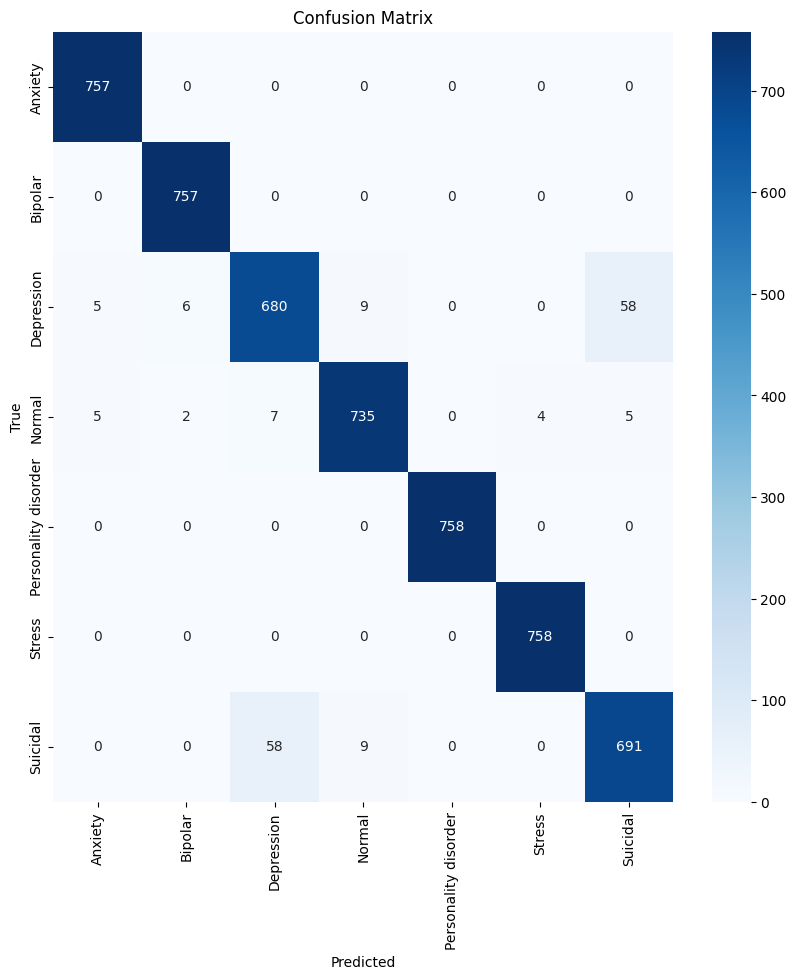

In [ ]:
print("\n--- Evaluating on the Test Set ---")
test_results = trainer.evaluate(test_dataset)
print("\nTest Set Results:")
print(test_results)

# Classification Report
print("\nTest Classification Report:")
test_preds = trainer.predict(test_dataset)
preds_flat = np.argmax(test_preds.predictions, axis=-1)
labels_flat = test_preds.label_ids
print(classification_report(labels_flat, preds_flat, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(labels_flat, preds_flat)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/saved_multilingual_mental_status_bert'

print(f"\n--- Saving Model and Assets to {SAVE_PATH} ---")
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

# Save the LabelEncoder
with open(f'{SAVE_PATH}/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


--- Saving Model and Assets to /content/drive/MyDrive/saved_multilingual_mental_status_bert ---


In [50]:
model_inference.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [51]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_english(text: str) -> str:
    """
    Clean English text: lowercase, keep letters + spaces, remove stopwords.
    DO NOT use this function for Burmese or other languages.
    """
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # Keep only English letters and spaces
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    # Remove stopwords
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
def detection_multilingual(input_text: str) -> str:
    if not isinstance(input_text, str):
        input_text = str(input_text)
    raw_text = input_text.strip()
    if raw_text == "":
        return "Unknown"

    # 1) Detect language on raw text
    try:
        detected_lang = detect(raw_text)
    except Exception:
        detected_lang = 'unknown'

    print(f"[INFO] Detected language: {detected_lang}")

    # 2) If English → clean; otherwise → use raw text
    if detected_lang == 'en':
        text_for_model = clean_english(raw_text)
        print(f"[INFO] English cleaned text: {text_for_model}")
    else:
        text_for_model = raw_text
        print("[INFO] Using raw text for non-English language (no cleaning).")

    if text_for_model.strip() == "":
        text_for_model = raw_text
        print("[WARN] Cleaned text is empty, falling back to raw text.")

    # 3) Tokenize
    inputs = tokenizer_inference(
        text_for_model,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=200
    )

    # 4) Predict
    with torch.no_grad():
        outputs = model_inference(**inputs)

    logits = outputs.logits
    prediction_label = torch.argmax(logits, dim=1).item()
    predicted_status = label_encoder_inference.inverse_transform([prediction_label])[0]

    return predicted_status


In [57]:
en_test = "I feel very sad and empty these days."
print("\n[TEST] English input:")
print("Input:", en_test)
print("Predicted Status:", detection_multilingual(en_test))

# Test Burmese
my_test = "အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။"
print("\n[TEST] Burmese input:")
print("Input:", my_test)
print("Predicted Status:", detection_multilingual(my_test))


[TEST] English input:
Input: I feel very sad and empty these days.
[INFO] Detected language: en
[INFO] English cleaned text: feel sad empty days
Predicted Status: Suicidal

[TEST] Burmese input:
Input: အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။
[INFO] Detected language: unknown
[INFO] Using raw text for non-English language (no cleaning).
Predicted Status: Normal


In [58]:
# Test English
english_test = "I feel like I can't keep going anymore."
print(f"\nEnglish Test Input: '{english_test}'")
print(f"Predicted Status: {detection_multilingual(english_test)}")

# Test Burmese (Placeholder text)
burmese_test = "လူတိုင်းက ကျွန်တော်ကို မုန်းကြလို့ နောင်တလျှင် မနေချင်တော့ဘူး"
print(f"\nBurmese Test Input: '{burmese_test}'")
print(f"Predicted Status: {detection_multilingual(burmese_test)}")


English Test Input: 'I feel like I can't keep going anymore.'
[INFO] Detected language: af
[INFO] Using raw text for non-English language (no cleaning).
Predicted Status: Suicidal

Burmese Test Input: 'လူတိုင်းက ကျွန်တော်ကို မုန်းကြလို့ နောင်တလျှင် မနေချင်တော့ဘူး'
[INFO] Detected language: unknown
[INFO] Using raw text for non-English language (no cleaning).
Predicted Status: Normal


# Test - 3

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import asyncio
import nest_asyncio
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from datasets import Dataset
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
!pip install googletrans
from googletrans import Translator
!pip install langdetect
from langdetect import detect # For inference language detection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=40e5d82cc7c5c7f868a361dfee434d28a11ee9b35c3a91deb3f908395e74ce9a
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [6]:
#SETUP AND INITIALIZATION
nest_asyncio.apply()
nltk.download('stopwords', quiet=True)
stop_words = set(nltk.corpus.stopwords.words('english'))

In [7]:
# Initialize Translator
try:
    translator = Translator()
except Exception as e:
    print(f"Translator initialization failed: {e}")
    translator = None

data.dropna(inplace=True)
data = data.sample(n=2000, random_state=42).reset_index(drop=True)

def clean_statement(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()

    # Keep only English letters and spaces
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove English stopwords
    words = [w for w in text.split() if w not in stop_words]
    text = " ".join(words)

    return text

In [8]:
data['statement_en'] = data['statement'].apply(clean_statement)

print("Sample cleaned English:")
print(data['statement_en'].head())

Sample cleaned English:
0                      whatever nominal still grateful
1    trouble sleeping thought would vent herei grad...
2    know people absolutely nothing clothes back ro...
3    dutifully working job care humanity training p...
4    year old full time single father mother care e...
Name: statement_en, dtype: object


In [31]:
import pandas as pd

async def translate_en_to_my(text):
    if pd.isna(text) or str(text).strip() == "":
        return ""
    try:
        # IMPORTANT: await the translator
        result = await translator.translate(text, src='en', dest='my')
        # If `result` has `.text`, return it; otherwise just return `result`
        return getattr(result, "text", result)
    except Exception as e:
        print("Translation error:", e, repr(text))
        return text


In [32]:
translated = await translate_en_to_my("Hello, how are you?")
print(translated)

ဟယ်လိုနေကောင်းလား?


In [33]:
async def translate_series_to_my(series):
    results = []
    for txt in series:
        res = await translate_en_to_my(txt)
        results.append(res)
    return results

data['statement_my'] = await translate_series_to_my(data['statement_en'])

print("Sample Burmese translation:")
print(data[['statement_en', 'statement_my']].head())


Sample Burmese translation:
                                        statement_en  \
0                    whatever nominal still grateful   
1  trouble sleeping thought would vent herei grad...   
2  know people absolutely nothing clothes back ro...   
3  dutifully working job care humanity training p...   
4  year old full time single father mother care e...   

                                        statement_my  
0                   မည်သည့်အမည်ခံနေဆဲကျေးဇူးတင်ပါတယ်  
1  အိပ်ပျော်နေသောအတွေးအခေါ်များဤနေရာတွင် 0 င်ရောက...  
2  လူတို့အားအဘယ်အရာကိုမျှမသိဘဲအဘယ်အရာကိုမျှအဘယ်အရ...  
3  တာဝန်ရှိသည့်အလုပ်ခွင်တွင်လူတို့အားလက်တွေ့ကျသော...  
4  တစ်နှစ်တာအချိန်ပြည့်ကြင်ဖော်မဲ့ဖခင်စောင့်ရှောက...  


/usr/local/lib/python3.12/dist-packages/pandas/core/frame.py:4478: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  self._mgr.iset(loc, value, inplace=inplace, refs=refs)


In [34]:
output_path = "/content/Combined_Data_2000_en_my.csv"
data.to_csv(output_path, index=False)
print("Saved English + Burmese CSV to:", output_path)

Saved English + Burmese CSV to: /content/Combined_Data_2000_en_my.csv


In [35]:
from imblearn.over_sampling import RandomOverSampler

# Features = texts (both languages)
X = data[['statement_en', 'statement_my']]
y = data['status']

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

print("\n--- Data Statistics ---")
print("Class distribution after oversampling:")
print(data['status'].value_counts())


--- Data Statistics ---
Class distribution after oversampling:
status
Normal        659
Depression    659
Stress        659
Suicidal      659
Anxiety       659
Name: count, dtype: int64


In [36]:
data.head()

,statement_en,statement_my,status
0,whatever nominal still grateful,မည်သည့်အမည်ခံနေဆဲကျေးဇူးတင်ပါတယ်,Normal
1,trouble sleeping thought would vent herei grad...,အိပ်ပျော်နေသောအတွေးအခေါ်များဤနေရာတွင် 0 င်ရောက...,Depression
2,know people absolutely nothing clothes back ro...,လူတို့အားအဘယ်အရာကိုမျှမသိဘဲအဘယ်အရာကိုမျှအဘယ်အရ...,Stress
3,dutifully working job care humanity training p...,တာဝန်ရှိသည့်အလုပ်ခွင်တွင်လူတို့အားလက်တွေ့ကျသော...,Depression
4,year old full time single father mother care e...,တစ်နှစ်တာအချိန်ပြည့်ကြင်ဖော်မဲ့ဖခင်စောင့်ရှောက...,Suicidal


In [37]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])
num_labels = len(label_encoder.classes_)
print("Labels:", dict(zip(label_encoder.classes_, range(num_labels))))


Labels: {'Anxiety': 0, 'Depression': 1, 'Normal': 2, 'Stress': 3, 'Suicidal': 4}


In [38]:
train_en, test_en, train_my, test_my, train_labels, test_labels = train_test_split(
    data['statement_en'],
    data['statement_my'],
    data['label'],
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)


In [39]:
MULTILINGUAL_MODEL_NAME = "bert-base-multilingual-cased"

tokenizer = BertTokenizer.from_pretrained(MULTILINGUAL_MODEL_NAME)

# Train encoding with text + text_pair
train_encoding = tokenizer(
    list(train_en),
    list(train_my),
    padding=True,
    truncation=True,
    max_length=200,
    return_tensors=None
)

test_encoding = tokenizer(
    list(test_en),
    list(test_my),
    padding=True,
    truncation=True,
    max_length=200,
    return_tensors=None
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [40]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encoding['input_ids'],
    'attention_mask': train_encoding['attention_mask'],
    'token_type_ids': train_encoding['token_type_ids'],
    'labels': train_labels.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encoding['input_ids'],
    'attention_mask': test_encoding['attention_mask'],
    'token_type_ids': test_encoding['token_type_ids'],
    'labels': test_labels.tolist()
})


In [42]:
print(f"\n--- Loading Multilingual BERT Model: {MULTILINGUAL_MODEL_NAME} ---")
model = AutoModelForSequenceClassification.from_pretrained(
    MULTILINGUAL_MODEL_NAME,
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="./results_multilingual",
    eval_strategy="epoch",      # Changed 'evaluation_strategy' to 'eval_strategy'
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_multilingual',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("\n--- Starting Training ---")
trainer.train()


--- Loading Multilingual BERT Model: bert-base-multilingual-cased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Training ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aungthuphyo13072021 (aungthuphyo13072021-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.553200,0.952970,0.661608,0.634286,0.655444,0.661608


TrainOutput(global_step=165, training_loss=1.4153871940843987, metrics={'train_runtime': 153.3082, 'train_samples_per_second': 17.194, 'train_steps_per_second': 1.076, 'total_flos': 270929462318400.0, 'train_loss': 1.4153871940843987, 'epoch': 1.0})


--- Evaluating on the Test Set ---



Test Set Results:
{'eval_loss': 0.9529701471328735, 'eval_accuracy': 0.661608497723824, 'eval_f1': 0.6342862479092213, 'eval_precision': 0.6554437324370442, 'eval_recall': 0.661608497723824, 'eval_runtime': 7.1355, 'eval_samples_per_second': 92.355, 'eval_steps_per_second': 5.886, 'epoch': 1.0}

Test Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.78      0.75      0.76       132
  Depression       0.51      0.16      0.24       131
      Normal       0.80      0.83      0.81       132
      Stress       0.69      0.83      0.75       132
    Suicidal       0.50      0.73      0.59       132

    accuracy                           0.66       659
   macro avg       0.66      0.66      0.63       659
weighted avg       0.66      0.66      0.63       659



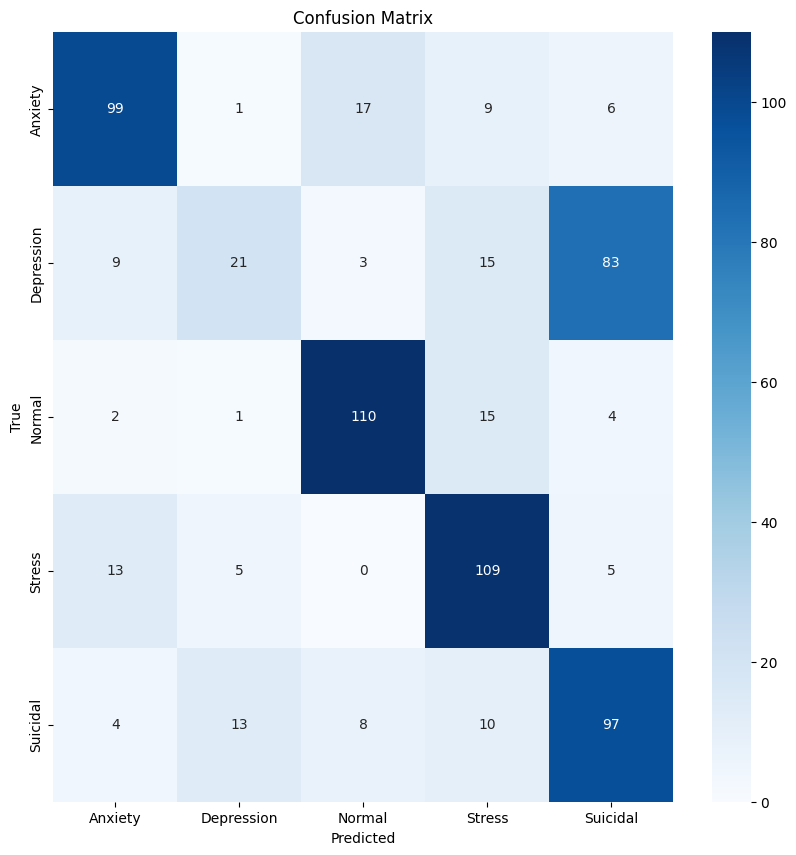

In [43]:
print("\n--- Evaluating on the Test Set ---")
test_results = trainer.evaluate(test_dataset)
print("\nTest Set Results:")
print(test_results)

# Classification Report
print("\nTest Classification Report:")
test_preds = trainer.predict(test_dataset)
preds_flat = np.argmax(test_preds.predictions, axis=-1)
labels_flat = test_preds.label_ids
print(classification_report(labels_flat, preds_flat, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(labels_flat, preds_flat)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [59]:
SAVE_PATH = '/content/drive/MyDrive/saved_multilingual_mental_status_bert'

print(f"\n--- Saving Model and Assets to {SAVE_PATH} ---")
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

# Save the LabelEncoder
with open(f'{SAVE_PATH}/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


--- Saving Model and Assets to /content/drive/MyDrive/saved_multilingual_mental_status_bert ---


In [60]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_english(text: str) -> str:
    """
    Clean English text: lowercase, keep letters + spaces, remove stopwords.
    DO NOT use this function for Burmese or other languages.
    """
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # Keep only English letters and spaces
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    # Remove stopwords
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
def detection_multilingual(input_text: str) -> str:
    if not isinstance(input_text, str):
        input_text = str(input_text)
    raw_text = input_text.strip()
    if raw_text == "":
        return "Unknown"

    # 1) Detect language on raw text
    try:
        detected_lang = detect(raw_text)
    except Exception:
        detected_lang = 'unknown'

    print(f"[INFO] Detected language: {detected_lang}")

    # 2) If English → clean; otherwise → use raw text
    if detected_lang == 'en':
        text_for_model = clean_english(raw_text)
        print(f"[INFO] English cleaned text: {text_for_model}")
    else:
        text_for_model = raw_text
        print("[INFO] Using raw text for non-English language (no cleaning).")

    if text_for_model.strip() == "":
        text_for_model = raw_text
        print("[WARN] Cleaned text is empty, falling back to raw text.")

    # 3) Tokenize
    inputs = tokenizer_inference(
        text_for_model,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=200
    )

    # 4) Predict
    with torch.no_grad():
        outputs = model_inference(**inputs)

    logits = outputs.logits
    prediction_label = torch.argmax(logits, dim=1).item()
    predicted_status = label_encoder_inference.inverse_transform([prediction_label])[0]

    return predicted_status


In [63]:
# Test English
english_test = "I feel like I can't keep going anymore."
print(f"\nEnglish Test Input: '{english_test}'")
print(f"Predicted Status: {detection_multilingual(english_test)}")

# Test Burmese (Placeholder text)
burmese_test = "မနေချင်တော့ဘူး"
print(f"\nBurmese Test Input: '{burmese_test}'")
print(f"Predicted Status: {detection_multilingual(burmese_test)}")


English Test Input: 'I feel like I can't keep going anymore.'
[INFO] Detected language: af
[INFO] Using raw text for non-English language (no cleaning).
Predicted Status: Suicidal

Burmese Test Input: 'မနေချင်တော့ဘူး'
[INFO] Detected language: unknown
[INFO] Using raw text for non-English language (no cleaning).
Predicted Status: Normal


In [49]:
# Test Burmese (Placeholder text)
burmese_test = "အဘယ်အရာကိုမျှအဘယ်အရာကိုမျှအဘယ်အရာကိုမျှအဘယ်အရာကိုမျှမနွေးပါ"
print(f"\nBurmese Test Input: '{burmese_test}'")
print(f"Predicted Status: {detection_multilingual(burmese_test)}")


Burmese Test Input: 'အဘယ်အရာကိုမျှအဘယ်အရာကိုမျှအဘယ်အရာကိုမျှအဘယ်အရာကိုမျှမနွေးပါ'
Predicted Status: Normal


In [64]:
import torch
import torch.nn.functional as F
from langdetect import detect

def predict_with_probs(input_text: str):
    """
    Return predicted label + probability for each class
    for English or non-English (e.g., Burmese) input.
    """
    if not isinstance(input_text, str):
        input_text = str(input_text)
    raw_text = input_text.strip()
    if raw_text == "":
        return "Unknown", {}

    # 1) Detect language
    try:
        detected_lang = detect(raw_text)
    except Exception:
        detected_lang = 'unknown'

    print(f"[INFO] Detected language: {detected_lang}")

    # 2) Prepare text_for_model
    if detected_lang == 'en':
        text_for_model = clean_english(raw_text)
        print(f"[INFO] English cleaned text: {text_for_model}")
    else:
        text_for_model = raw_text
        print("[INFO] Using raw text for non-English language (no cleaning).")

    if text_for_model.strip() == "":
        text_for_model = raw_text
        print("[WARN] Cleaned text is empty, falling back to raw text.")

    # 3) Tokenize
    inputs = tokenizer_inference(
        text_for_model,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=200
    )

    # 4) Model prediction + softmax
    with torch.no_grad():
        outputs = model_inference(**inputs)

    logits = outputs.logits  # shape [1, num_labels]
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]  # shape [num_labels]

    # 5) Convert to label names
    label_ids = list(range(len(label_encoder_inference.classes_)))
    label_names = label_encoder_inference.inverse_transform(label_ids)

    prob_dict = {name: float(p) for name, p in zip(label_names, probs)}
    pred_idx = int(torch.argmax(logits, dim=1).item())
    pred_label = label_encoder_inference.inverse_transform([pred_idx])[0]

    return pred_label, prob_dict


In [65]:
test_sentences = [
    # English
    "I feel very sad and empty these days.",
    "I am okay, just a bit tired from work.",
    "I want to die. There is no meaning in my life.",

    # Burmese (adjust text to what you want to test)
    "အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။",  # tired + sad
    "အခုဘဝက အမှန်အရမ်းခက်တယ်၊ အားလုံးစွန့်လွှတ်ချင်ပါတယ်။",       # more extreme
    "အခုတော့ အသက်ရှင်ရတာပင်ပန်းလောက်အောင် စိတ်ကျရောဂါလည်းရှိသလိုနာကျင်နေတယ်။"
]


In [66]:
for text in test_sentences:
    print("\n========================================")
    print("Input:", text)
    pred_label, prob_dict = predict_with_probs(text)
    print("Predicted Status:", pred_label)
    print("Probabilities:")
    for label, p in prob_dict.items():
        print(f"  {label:15s}: {p:.4f}")



Input: I feel very sad and empty these days.
[INFO] Detected language: en
[INFO] English cleaned text: feel sad empty days
Predicted Status: Suicidal
Probabilities:
  Anxiety        : 0.0542
  Depression     : 0.3027
  Normal         : 0.0763
  Stress         : 0.0823
  Suicidal       : 0.4845

Input: I am okay, just a bit tired from work.
[INFO] Detected language: en
[INFO] English cleaned text: okay bit tired work
Predicted Status: Normal
Probabilities:
  Anxiety        : 0.1904
  Depression     : 0.1733
  Normal         : 0.2762
  Stress         : 0.1764
  Suicidal       : 0.1837

Input: I want to die. There is no meaning in my life.
[INFO] Detected language: en
[INFO] English cleaned text: want die meaning life
Predicted Status: Suicidal
Probabilities:
  Anxiety        : 0.0500
  Depression     : 0.2736
  Normal         : 0.1114
  Stress         : 0.0786
  Suicidal       : 0.4864

Input: အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။
[INFO] Detected language: unknown
[INFO] 

# Test - 4

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

from transformers import BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

MULTILINGUAL_MODEL_NAME = "bert-base-multilingual-cased"  # or your model

# 1. Load your augmented CSV (with statement_en + statement_my + status)
data = pd.read_csv("/content/Combined_Data_2000_en_my.csv")

# 2. Create combined text: English + SEP + Burmese
data['text_combined'] = (
    data['statement_en'].fillna('')
    + ' [SEP] ' +
    data['statement_my'].fillna('')
)

# 3. Oversample on features + labels
X = data[['text_combined']]
y = data['status']

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = ros.fit_resample(X, y)

data_res = pd.concat([X_res, y_res], axis=1)

# 4. Label encode
label_encoder = LabelEncoder()
data_res['label'] = label_encoder.fit_transform(data_res['status'])
num_labels = len(label_encoder.classes_)

# 5. Train–test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_res['text_combined'],
    data_res['label'],
    test_size=0.2,
    random_state=42,
    stratify=data_res['label']
)

# 6. Tokenizer
tokenizer = BertTokenizer.from_pretrained(MULTILINGUAL_MODEL_NAME)

train_encoding = tokenizer(
    list(train_texts),
    padding=True,
    truncation=True,
    max_length=200
)
test_encoding = tokenizer(
    list(test_texts),
    padding=True,
    truncation=True,
    max_length=200
)

# 7. Build Dataset objects
train_dataset = Dataset.from_dict({
    'input_ids': train_encoding['input_ids'],
    'attention_mask': train_encoding['attention_mask'],
    'labels': train_labels.tolist()
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encoding['input_ids'],
    'attention_mask': test_encoding['attention_mask'],
    'labels': test_labels.tolist()
})

# 8. Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MULTILINGUAL_MODEL_NAME,
    num_labels=num_labels
)

# 9. TrainingArgs + metrics
training_args = TrainingArguments(
    output_dir="./results_multilingual_bi",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_multilingual_bi',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("\n--- Starting bilingual training (EN + MY) ---")
trainer.train()

# 10. Save model + tokenizer + label encoder
SAVE_PATH = "/content/drive/MyDrive/saved_multilingual_mental_status_bert_bi"

trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

import pickle
with open(f"{SAVE_PATH}/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting bilingual training (EN + MY) ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.449600,0.824147,0.710167,0.732437,0.710167,0.685812
2,0.653800,0.576489,0.748103,0.778791,0.748103,0.737932


In [76]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_english(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
def detection_bilingual(input_text: str) -> str:
    """
    Use the EN+MY bilingual model.
    - If input is English: use as English side.
    - If input is non-English (e.g., Burmese): use as Burmese side.
    """
    if not isinstance(input_text, str):
        input_text = str(input_text)
    raw_text = input_text.strip()
    if raw_text == "":
        return "Unknown"

    # 1) Detect language
    try:
        detected_lang = detect(raw_text)
    except Exception:
        detected_lang = "unknown"

    print(f"[INFO] Detected language: {detected_lang}")

    # 2) Build text_combined THE SAME WAY as training, but from user input
    if detected_lang == "en":
        en_clean = clean_english(raw_text)
        # English side filled, Burmese side empty
        text_combined = en_clean + " [SEP] "
        print(f"[INFO] text_combined (EN side): '{text_combined}'")
    else:
        # Non-English -> treat as Burmese side, English empty
        text_combined = " [SEP] " + raw_text
        print(f"[INFO] text_combined (MY/other side): '{text_combined}'")

    if text_combined.strip() == "":
        text_combined = raw_text
        print("[WARN] text_combined empty, falling back to raw text.")

    # 3) Tokenize
    inputs = tokenizer_bi(
        text_combined,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=200
    )

    # 4) Predict
    with torch.no_grad():
        outputs = model_bi(**inputs)

    logits = outputs.logits
    pred_idx = int(torch.argmax(logits, dim=1).item())
    predicted_status = label_encoder_bi.inverse_transform([pred_idx])[0]

    return predicted_status


In [78]:
import torch.nn.functional as F

def predict_with_probs_bi(input_text: str):
    if not isinstance(input_text, str):
        input_text = str(input_text)
    raw_text = input_text.strip()
    if raw_text == "":
        return "Unknown", {}

    try:
        detected_lang = detect(raw_text)
    except Exception:
        detected_lang = "unknown"

    print(f"[INFO] Detected language: {detected_lang}")

    if detected_lang == "en":
        en_clean = clean_english(raw_text)
        text_combined = en_clean + " [SEP] "
        print(f"[INFO] text_combined (EN side): '{text_combined}'")
    else:
        text_combined = " [SEP] " + raw_text
        print(f"[INFO] text_combined (MY/other side): '{text_combined}'")

    if text_combined.strip() == "":
        text_combined = raw_text
        print("[WARN] text_combined empty, falling back to raw text.")

    inputs = tokenizer_bi(
        text_combined,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=200
    )

    with torch.no_grad():
        outputs = model_bi(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    label_ids = list(range(len(label_encoder_bi.classes_)))
    label_names = label_encoder_bi.inverse_transform(label_ids)

    prob_dict = {name: float(p) for name, p in zip(label_names, probs)}
    pred_idx = int(torch.argmax(logits, dim=1).item())
    pred_label = label_encoder_bi.inverse_transform([pred_idx])[0]

    return pred_label, prob_dict


In [79]:
test_sentences = [
    "I feel very sad and empty these days.",
    "I want to die. There is no meaning in my life.",
    "အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။",
    "အခုဘဝက အမှန်အရမ်းခက်တယ်၊ အားလုံးစွန့်လွှတ်ချင်ပါတယ်။",
]

for text in test_sentences:
    print("\n========================================")
    print("Input:", text)
    pred, probs = predict_with_probs_bi(text)
    print("Predicted Status:", pred)
    print("Probabilities:")
    for label, p in probs.items():
        print(f"  {label:10s}: {p:.4f}")



Input: I feel very sad and empty these days.
[INFO] Detected language: en
[INFO] text_combined (EN side): 'feel sad empty days [SEP] '
Predicted Status: Suicidal
Probabilities:
  Anxiety   : 0.0119
  Depression: 0.4353
  Normal    : 0.0216
  Stress    : 0.0058
  Suicidal  : 0.5254

Input: I want to die. There is no meaning in my life.
[INFO] Detected language: en
[INFO] text_combined (EN side): 'want die meaning life [SEP] '
Predicted Status: Suicidal
Probabilities:
  Anxiety   : 0.0075
  Depression: 0.3335
  Normal    : 0.0194
  Stress    : 0.0071
  Suicidal  : 0.6325

Input: အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။
[INFO] Detected language: unknown
[INFO] text_combined (MY/other side): ' [SEP] အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။'
Predicted Status: Normal
Probabilities:
  Anxiety   : 0.0102
  Depression: 0.0146
  Normal    : 0.9328
  Stress    : 0.0057
  Suicidal  : 0.0367

Input: အခုဘဝက အမှန်အရမ်းခက်တယ်၊ အားလုံးစွန့်လွှတ်ချင်ပါတယ်။
[INFO] Detected langua

In [74]:
SAVE_PATH = "/content/drive/MyDrive/saved_multilingual_mental_status_bert_bi"

# Load the bilingual model, tokenizer, and label encoder
model_bi = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH)
tokenizer_bi = BertTokenizer.from_pretrained(SAVE_PATH)
with open(f"{SAVE_PATH}/label_encoder.pkl", "rb") as f:
    label_encoder_bi = pickle.load(f)

test_sentences = [
    "I feel very sad and empty these days.",
    "I am okay, just a bit tired from work.",
    "I want to die. There is no meaning in my life.",
    "အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။",
    "အခုဘဝက အမှန်အရမ်းခက်တယ်၊ အားလုံးစွန့်လွှတ်ချင်ပါတယ်။",
    "အခုတော့ အသက်ရှင်ရတာပင်ပန်းလောက်အောင် စိတ်ကျရောဂါလည်းရှိသလိုနာကျင်နေတယ်။"
]

for text in test_sentences:
    print("\n========================================")
    print("Input:", text)
    pred, probs = predict_with_probs_bi(text)
    print("Predicted Status:", pred)
    print("Probabilities:")
    for label, p in probs.items():
        print(f"  {label:10s}: {p:.4f}")


Input: I feel very sad and empty these days.
[INFO] Detected language: en
[INFO] text_combined (EN side): 'feel sad empty days [SEP] '
Predicted Status: Suicidal
Probabilities:
  Anxiety   : 0.0119
  Depression: 0.4353
  Normal    : 0.0216
  Stress    : 0.0058
  Suicidal  : 0.5254

Input: I am okay, just a bit tired from work.
[INFO] Detected language: en
[INFO] text_combined (EN side): 'okay bit tired work [SEP] '
Predicted Status: Suicidal
Probabilities:
  Anxiety   : 0.0605
  Depression: 0.3804
  Normal    : 0.0940
  Stress    : 0.0123
  Suicidal  : 0.4528

Input: I want to die. There is no meaning in my life.
[INFO] Detected language: en
[INFO] text_combined (EN side): 'want die meaning life [SEP] '
Predicted Status: Suicidal
Probabilities:
  Anxiety   : 0.0075
  Depression: 0.3335
  Normal    : 0.0194
  Stress    : 0.0071
  Suicidal  : 0.6325

Input: အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။
[INFO] Detected language: unknown
[INFO] text_combined (MY/other side): ' [SEP

# Test - 4

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

from transformers import BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

MULTILINGUAL_MODEL_NAME = "bert-base-multilingual-cased"

# 1. Load your CSV (with statement_en, statement_my, status)
data = pd.read_csv("/content/Combined_Data_2000_en_my.csv")

# 2. Build English-only rows
en_df = data[['statement_en', 'status']].copy()
en_df.rename(columns={'statement_en': 'text'}, inplace=True)

# 3. Build Burmese-only rows
my_df = data[['statement_my', 'status']].copy()
my_df.rename(columns={'statement_my': 'text'}, inplace=True)

# 4. Concatenate to make a bilingual dataset
bi_df = pd.concat([en_df, my_df], ignore_index=True)
bi_df.dropna(subset=['text', 'status'], inplace=True)
bi_df.reset_index(drop=True, inplace=True)

print("Bilingual dataset shape:", bi_df.shape)
print(bi_df.head())


Bilingual dataset shape: (3974, 2)
                                                text      status
0                    whatever nominal still grateful      Normal
1  trouble sleeping thought would vent herei grad...  Depression
2  know people absolutely nothing clothes back ro...      Stress
3  dutifully working job care humanity training p...  Depression
4  year old full time single father mother care e...    Suicidal


In [81]:
X = bi_df[['text']]
y = bi_df['status']

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = ros.fit_resample(X, y)

data_res = pd.concat([X_res, y_res], axis=1)

label_encoder = LabelEncoder()
data_res['label'] = label_encoder.fit_transform(data_res['status'])
num_labels = len(label_encoder.classes_)

print("Label classes:", label_encoder.classes_)


Label classes: ['Anxiety' 'Depression' 'Normal' 'Stress' 'Suicidal']


In [82]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_res['text'],
    data_res['label'],
    test_size=0.2,
    random_state=42,
    stratify=data_res['label']
)


In [83]:
tokenizer = BertTokenizer.from_pretrained(MULTILINGUAL_MODEL_NAME)

train_encoding = tokenizer(
    list(train_texts),
    padding=True,
    truncation=True,
    max_length=200
)
test_encoding = tokenizer(
    list(test_texts),
    padding=True,
    truncation=True,
    max_length=200
)

train_dataset = Dataset.from_dict({
    'input_ids': train_encoding['input_ids'],
    'attention_mask': train_encoding['attention_mask'],
    'labels': train_labels.tolist()
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encoding['input_ids'],
    'attention_mask': test_encoding['attention_mask'],
    'labels': test_labels.tolist()
})


In [85]:
model = AutoModelForSequenceClassification.from_pretrained(
    MULTILINGUAL_MODEL_NAME,
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="./results_multilingual_single",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_multilingual_single',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("\n--- Starting multilingual single-text training (EN + MY) ---")
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting multilingual single-text training (EN + MY) ---


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.020200,0.867467,0.623065,0.633435,0.623065,0.587018
2,0.739200,0.588852,0.728328,0.774281,0.728328,0.697062


TrainOutput(global_step=646, training_loss=1.009763705841159, metrics={'train_runtime': 413.9733, 'train_samples_per_second': 24.968, 'train_steps_per_second': 1.56, 'total_flos': 1062339500198400.0, 'train_loss': 1.009763705841159, 'epoch': 2.0})

In [86]:
SAVE_PATH = "/content/drive/MyDrive/saved_multilingual_mental_status_bert_single"

trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

import pickle
with open(f"{SAVE_PATH}/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [ ]:
from transformers import AutoModelForSequenceClassification, BertTokenizer
import torch, torch.nn.functional as F
from langdetect import detect
import re, pickle

SAVE_PATH = "/content/drive/MyDrive/saved_multilingual_mental_status_bert_single"

model_inf = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH)
tokenizer_inf = BertTokenizer.from_pretrained(SAVE_PATH)
with open(f"{SAVE_PATH}/label_encoder.pkl", "rb") as f:
    label_encoder_inf = pickle.load(f)

model_inf.eval()


In [87]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_english(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
def predict_multilingual(text):
    if not isinstance(text, str):
        text = str(text)
    raw = text.strip()
    if raw == "":
        return "Unknown", {}

    try:
        lang = detect(raw)
    except Exception:
        lang = "unknown"

    print(f"[INFO] Detected language: {lang}")

    if lang == 'en':
        text_for_model = clean_english(raw)
    else:
        text_for_model = raw   # Burmese or other languages: use as-is

    inputs = tokenizer_inf(
        text_for_model,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=200
    )

    with torch.no_grad():
        outputs = model_inf(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    label_ids = list(range(len(label_encoder_inf.classes_)))
    label_names = label_encoder_inf.inverse_transform(label_ids)

    prob_dict = {name: float(p) for name, p in zip(label_names, probs)}
    pred_idx = int(torch.argmax(logits, dim=1).item())
    pred_label = label_encoder_inf.inverse_transform([pred_idx])[0]

    return pred_label, prob_dict


In [91]:
from transformers import AutoModelForSequenceClassification, BertTokenizer
import torch, torch.nn.functional as F
from langdetect import detect
import re, pickle
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

SAVE_PATH = "/content/drive/MyDrive/saved_multilingual_mental_status_bert_single"

# Load the model, tokenizer, and label encoder
model_inf = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH)
tokenizer_inf = BertTokenizer.from_pretrained(SAVE_PATH)
with open(f"{SAVE_PATH}/label_encoder.pkl", "rb") as f:
    label_encoder_inf = pickle.load(f)

model_inf.eval()

def clean_english(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

def predict_multilingual(text):
    if not isinstance(text, str):
        text = str(text)
    raw = text.strip()
    if raw == "":
        return "Unknown", {}

    try:
        lang = detect(raw)
    except Exception:
        lang = "unknown"

    print(f"[INFO] Detected language: {lang}")

    if lang == 'en':
        text_for_model = clean_english(raw)
    else:
        text_for_model = raw   # Burmese or other languages: use as-is

    inputs = tokenizer_inf(
        text_for_model,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=200
    )

    with torch.no_grad():
        outputs = model_inf(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    label_ids = list(range(len(label_encoder_inf.classes_)))
    label_names = label_encoder_inf.inverse_transform(label_ids)

    prob_dict = {name: float(p) for name, p in zip(label_names, probs)}
    pred_idx = int(torch.argmax(logits, dim=1).item())
    pred_label = label_encoder_inf.inverse_transform([pred_idx])[0]

    return pred_label, prob_dict

for s in [
    "I want to die. There is no meaning in my life.",
    "အခုဘဝက အမှန်အရမ်းခက်တယ်၊ အားလုံးစွန့်လွှတ်ချင်ပါတယ်။",
    "အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။"
]:
    print("\n======================================")
    print("Input:", s)
    label, probs = predict_multilingual(s)
    print("Predicted:", label)
    for k, v in probs.items():
        print(f"  {k:10s}: {v:.4f}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Input: I want to die. There is no meaning in my life.
[INFO] Detected language: en
Predicted: Suicidal
  Anxiety   : 0.0192
  Depression: 0.1602
  Normal    : 0.3904
  Stress    : 0.0041
  Suicidal  : 0.4261

Input: အခုဘဝက အမှန်အရမ်းခက်တယ်၊ အားလုံးစွန့်လွှတ်ချင်ပါတယ်။
[INFO] Detected language: unknown
Predicted: Suicidal
  Anxiety   : 0.0405
  Depression: 0.3979
  Normal    : 0.0171
  Stress    : 0.0147
  Suicidal  : 0.5298

Input: အခုလေးနေ့တွေမှာ စိတ်အရမ်းပင်ပန်းပြီး ဝမ်းနည်းနေတာပဲ။
[INFO] Detected language: unknown
Predicted: Suicidal
  Anxiety   : 0.0308
  Depression: 0.3627
  Normal    : 0.0280
  Stress    : 0.0067
  Suicidal  : 0.5718


In [93]:
for s in [
    "အခုလေးခါးမှာ စိတ် လန်းဆန်းပြီး သွားနေတယ်။",
    "အိပ်ပြီး ပြန်မနိုးလာရင် ကောင်းမယ်"

]:
    print("\n======================================")
    print("Input:", s)
    label, probs = predict_multilingual(s)
    print("Predicted:", label)
    for k, v in probs.items():
        print(f"  {k:10s}: {v:.4f}")


Input: အခုလေးခါးမှာ စိတ် လန်းဆန်းပြီး သွားနေတယ်။
[INFO] Detected language: unknown
Predicted: Suicidal
  Anxiety   : 0.0827
  Depression: 0.3361
  Normal    : 0.0408
  Stress    : 0.1521
  Suicidal  : 0.3883

Input: အိပ်ပြီး ပြန်မနိုးလာရင် ကောင်းမယ်
[INFO] Detected language: unknown
Predicted: Normal
  Anxiety   : 0.0594
  Depression: 0.0559
  Normal    : 0.8055
  Stress    : 0.0021
  Suicidal  : 0.0770


In [94]:
for s in [
    # --- Normal (ပုံမှန် / ပျော်စရာ / သက်သာနေမှု) ---
    "ဒီနေ့ အားလုံးအဆင်ပြေတယ်၊ စိတ်လည်း နည်းနည်းပျော်နေတာပဲ။",
    "အလုပ်အနည်းငယ် ပင်ပန်းပေမယ့် စိတ်ရောင်အေးချမ်းနေတယ်။",

    # --- Anxiety (စိတ်လှုပ်ရှားမှု / စိုးရိမ်စိတ်) ---
    "အနာဂတ်အကြောင်းတွေအရမ်း စိုးရိမ်နေလိုက်ရလို့ စိတ်မ宁ဘူး။",
    "ဘာမှ မဖြစ်သေးပေမယ့် အမြဲမလုံခြုံသလို စိတ်ထဲမှာ ကြောက်စိတ်မကြာခဏတိုးလာတယ်။",

    # --- Depression (စိတ်ကျရောဂါ၊ ဝမ်းနည်းမှုနီူးနက်) ---
    "အခုလက်ရှိ ဘဝအပေါ်မှာ အရမ်းဝမ်းနည်းနေပြီး မည်သည့်အရာအပေါ်မှ စိတ်မပါတော့ဘူး။",
    "ဘာတွေလုပ်လုပ် စိတ်မလန်းတော့ဘူး၊ မျက်နှာပေါ်မှာ စမ်းသပ်ပျော်နေတာပဲ။",

    # --- Stress (ဖိဆန်မှု / ဖိအားများ) ---
    "အလုပ်ပမာဏများလွန်းလို့ ဖိအားအရမ်းကြီးနေပြီး အနားပဲယူချင်နေပြန်တယ်။",
    "စာဖတ်ရတာ၊ အလုပ်လုပ်ရတာ အကုန်တပြိုင်နက်လှုပ်ရှားလာလို့ ဦးခေါင်းကြီး အရမ်းဖိစီးနေတယ်။",

    # --- Suicidal ideation (သေချင်စိတ် / အလွန်နက်ရှိုင်းသည့် အနှောင့်အယှက်– but NO instructions) ---
    "အခြေအနေတွေ တအားလွန်းလို့ ဆက်အသက်ရှင်သွားရတာအပင်ပန်းတော့ စွန့်လွှတ်ချင်သလိုပဲရှိနေတယ်။",
    "အချိန်တလအောင် အဓိပ္ပါယ်မရှိသလို ခံစားနေရပြီး တစ်ခါတလေ ထပ်မနေချင်တဲ့စိတ်တောင် ရလာတယ်။",
]:
    print("\n======================================")
    print("Input:", s)
    label, probs = predict_multilingual(s)
    print("Predicted:", label)
    for k, v in probs.items():
        print(f"  {k:10s}: {v:.4f}")



Input: ဒီနေ့ အားလုံးအဆင်ပြေတယ်၊ စိတ်လည်း နည်းနည်းပျော်နေတာပဲ။
[INFO] Detected language: unknown
Predicted: Suicidal
  Anxiety   : 0.0393
  Depression: 0.3710
  Normal    : 0.0207
  Stress    : 0.0047
  Suicidal  : 0.5643

Input: အလုပ်အနည်းငယ် ပင်ပန်းပေမယ့် စိတ်ရောင်အေးချမ်းနေတယ်။
[INFO] Detected language: unknown
Predicted: Suicidal
  Anxiety   : 0.2539
  Depression: 0.3051
  Normal    : 0.0397
  Stress    : 0.0951
  Suicidal  : 0.3062

Input: အနာဂတ်အကြောင်းတွေအရမ်း စိုးရိမ်နေလိုက်ရလို့ စိတ်မ宁ဘူး။
[INFO] Detected language: zh-cn
Predicted: Anxiety
  Anxiety   : 0.9780
  Depression: 0.0080
  Normal    : 0.0045
  Stress    : 0.0038
  Suicidal  : 0.0058

Input: ဘာမှ မဖြစ်သေးပေမယ့် အမြဲမလုံခြုံသလို စိတ်ထဲမှာ ကြောက်စိတ်မကြာခဏတိုးလာတယ်။
[INFO] Detected language: unknown
Predicted: Suicidal
  Anxiety   : 0.0771
  Depression: 0.3428
  Normal    : 0.0309
  Stress    : 0.1179
  Suicidal  : 0.4313

Input: အခုလက်ရှိ ဘဝအပေါ်မှာ အရမ်းဝမ်းနည်းနေပြီး မည်သည့်အရာအပေါ်မှ စိတ်မပါတော့ဘူး။
[INFO] Detected 